In [1]:
import os
from copy import deepcopy

figure_dir = os.getcwd() + '/022025_experiment/figures'

In [2]:
from default import *
%cd -q {PROJECT_HOME}

In [3]:
PORT = 5000

In [23]:
import numpy as np
import torch
import mlflow
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from copy import deepcopy
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from models.architecture import MLP
from models.processing import StandardScaler
from torch import nn, dtype

import matplotlib as mpl
from matplotlib.lines import Line2D

from losses import StiffnessToLoadLoss

import ast

import torchmetrics.functional.regression as R
from dataset import FixedPrattTrussDatasetSingleTarget

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from tools.mlflow import BasicDataset

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

In [5]:
ds = FixedPrattTrussDatasetSingleTarget('data/dataset/pratt_truss_bridge/single_ea/train_100.hdf5')
k_s = (int(ds.stiffness_matrix[0].__len__() ** .5),) * 2
k_ref = ds.stiffness_matrix[0].reshape(k_s).astype(np.float64)
k_ref /= ds[0][1]
k_ref[[0, 1, 17], [0, 1, 17]] = 1
#k_ref[k_ref.abs() < 1e-9] = 0
k_ref = k_ref.to(torch.float32).to(device)

# Train procedures

In [19]:
def u_from_x(x, n_panels=8):
    batch_size = len(x)
    u = torch.zeros((batch_size, 4 * n_panels), device=x.device)
    u[:, 2:2 * n_panels + 1] = x[:, :2 * (n_panels - 1) + 1]
    u[:, 2 * (n_panels + 1):] = x[:, 2 * (n_panels - 1) + 1:4 * n_panels - 3]
    return u.unsqueeze(-1)


def q_from_x_q(x, q, n_panels=8):
    q = q.squeeze(-1)
    q[:, np.arange(3, 2 * n_panels, 2)] = x[:, 4 * n_panels - 3: 5 * n_panels - 4]

    return q.unsqueeze(-1)


def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion_data, criterion_phys, f_criterion_phys):
    model.train()

    input, target, _, u, q = batch
    input, target = input.to(device), target.to(device)
    u, q = u.to(device), q.to(device)
    q[:, [0, 1, 17], :] = 0.

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    k_pred = k_ref * target_pred.unsqueeze(-1)
    k_pred[:, [0, 1, 17], [0, 1, 17]] = 1.

    optimizer.zero_grad()
    loss_data = criterion_data(z_target_pred, z_target)
    loss_phys = criterion_phys(k_pred * 1e-6,
                               u_from_x(input, 8) * 1e3,
                               q_from_x_q(input, q, 8) * 1e-3)

    loss = loss_data + loss_phys * f_criterion_phys
    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss_data'] = loss_data.item()
    metrics['loss_phys'] = loss_phys.item()
    metrics['loss'] = loss.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion_data, criterion_phys, f_criterion_phys):
    model.eval()
    with torch.no_grad():
        input, target, _, u, q = batch
        input, target = input.to(device), target.to(device)
        u, q = u.to(device), q.to(device)
        q[:, [0, 1, 17], :] = 0.

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        k_pred = k_ref * target_pred.unsqueeze(-1)
        k_pred[:, [0, 1, 17], [0, 1, 17]] = 1.

        loss_data = criterion_data(z_target_pred, z_target)
        loss_phys = criterion_phys(k_pred * 1e-6,
                                   u_from_x(input, 8) * 1e3,
                                   q_from_x_q(input, q, 8) * 1e-3)
        loss = loss_data + loss_phys * f_criterion_phys

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss_data'] = loss_data.item()
    metrics['loss_phys'] = loss_phys.item()
    metrics['loss'] = loss.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss', 'loss_data', "loss_phys"] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss', 'loss_data', "loss_phys"] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer,
          criterion_data, criterion_phys, f_criterion_phys, log_step=10):
    model = model.to(device)
    criterion_phys = criterion_phys.to(device)
    criterion_data = criterion_data.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'loss_phys': {model: None, 'value': np.inf, 'epoch': -1},
        'loss_data': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer,
                                             criterion_data, criterion_phys, f_criterion_phys)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler,
                                           criterion_data, criterion_phys, f_criterion_phys)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch, train_metrics, val_metrics)

    input, target, _, _, _ = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch})


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion_data, criterion_phys, f_criterion_phys,
                  dataset_log, fold, log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': lr,
            'criterion_data': criterion_data.__name__,
            'criterion_phys': criterion_phys.__name__,
            'pinn_factor': f_criterion_phys
        })

        # Dataset information login
        for context, dataset in dataset_log.items():
            mlflow.log_input(dataset, context=context)

        # Run the training with the configuration
        train_routine(model, train_dataset, val_dataset,
                      train_batch_size, val_batch_size,
                      n_epoch, optimizer(model.parameters(), lr=lr),
                      criterion_data(), criterion_phys(), f_criterion_phys,
                      log_step=log_step)

# Hyperparameter tuning

# Training

## Factor

In [43]:
if False:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss+MSE_no_noise_pinn_scale")

    TRAIN_BATCH_SIZE = 512
    VAL_BATCH_SIZE = 256
    N_EPOCH = 200
    LR = 5e-3

    log_step = -1

    kfold = 5
    dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_2000.hdf5"
    ds = FixedPrattTrussDatasetSingleTarget(dataset_path)
    factor_values = np.logspace(-5, 0, 6)
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for f_pinn in factor_values:
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': [40 for _ in range(4)],
                                             'output_dim': 1,
                                             'activation': "gelu",
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, f_pinn,
                                         {
                                             'training': BasicDataset('2_000', dataset_path, 2_000, kfold,
                                                                      "60m long 7,5m high pratt truss"),
                                         }, kfold, log_step)
                futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

🏃 View run bright-carp-338 at: http://127.0.0.1:5000/#/experiments/919754750066893760/runs/1848d5dfa1ec48ff8595af3d3d1a98ea
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/919754750066893760
🏃 View run smiling-duck-468 at: http://127.0.0.1:5000/#/experiments/919754750066893760/runs/46165ff1cc7a4e6eabc83253d6e1251d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/919754750066893760
🏃 View run silent-horse-342 at: http://127.0.0.1:5000/#/experiments/919754750066893760/runs/bde0e417f70c430099aa5fb30a4071d3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/919754750066893760
🏃 View run bald-steed-55 at: http://127.0.0.1:5000/#/experiments/919754750066893760/runs/36c6aa0ea17541f29a28d59962794b6b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/919754750066893760
🏃 View run valuable-sponge-109 at: http://127.0.0.1:5000/#/experiments/919754750066893760/runs/27e6264e225e4e10bc938295e7f89d9d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/9197547500

In [44]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss+MSE_no_noise_pinn_scale")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

combinations = set(runs_df['params.pinn_factor'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in combinations}
for f in combinations:
    #run_ids = runs_df[(runs_df['params.pinn_factor'] == f) &
    #                  (runs_df['params.n_hidden_layers'] == '4') &
    #                  (runs_df['params.hidden_layers_size'] == '30')]['run_id']
    run_ids = runs_df[(runs_df['params.pinn_factor'] == f) &
                      (runs_df['params.n_hidden_layers'] == '4') &
                      (runs_df['params.hidden_layers_size'] == '40')]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[f][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

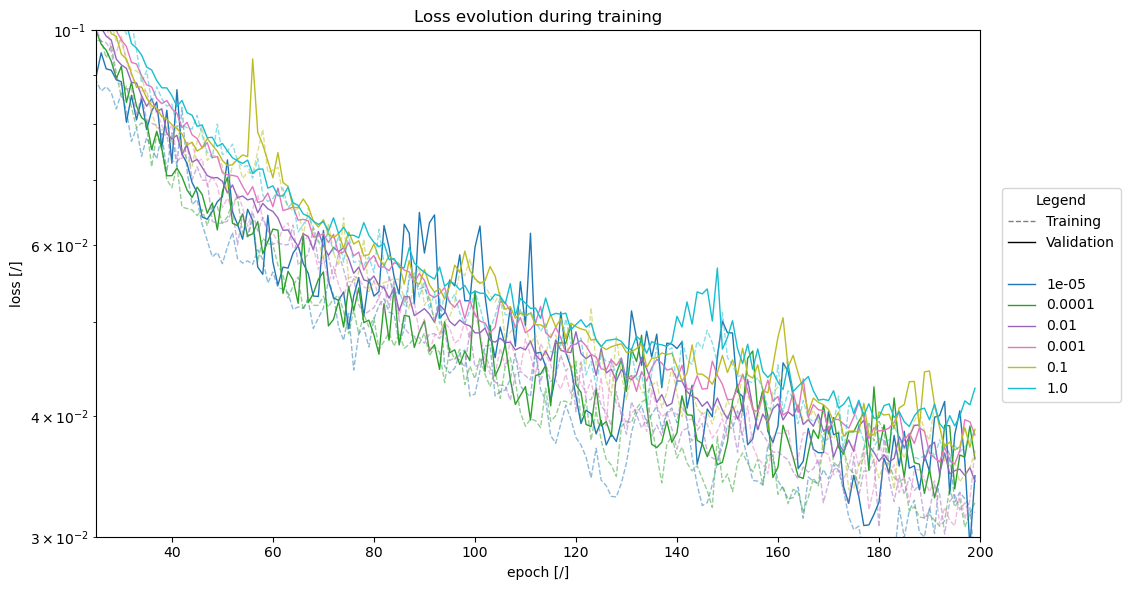

In [51]:
# Your existing code for preparing the data
_configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = _configs
configs = sorted(configs)
configs = [x[1] for x in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(configs)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data but collect the handles for the legend
config_handles = []
for i, capacity in enumerate(configs):
    # Store only the validation line handles for the legend
    l = len(results[capacity]['train_mape'])
    h = ax.plot(np.arange(l), results[capacity]['train_mape'], alpha=.5, ls='--', lw=1, c=c[i])[0]
    h2 = ax.plot(np.arange(l), results[capacity]['val_mape'], ls='-', lw=1, c=c[i])[0]
    config_handles.append(h2)

# Create custom handles for the line style legend
line_style_handles = [
    Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
    Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
]

# Get the current position and size of the axis
box = ax.get_position()
# Reduce the width of the axis to make room for the legend
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Combine both sets of handles and labels
all_handles = line_style_handles + config_handles
all_labels = ['Training', 'Validation', ''] + configs

# Create a single legend with both line styles and configurations
plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
              title="Legend")

ax.set_title("Loss evolution during training")
ax.set_yscale('log')
ax.set_ylabel("loss [/]")
ax.set_xlabel("epoch [/]")
ax.set_xlim(25, 200)
ax.set_ylim(0.03, .1)
plt.tight_layout()
# Adjust right padding to make room for the legend
plt.show()

## Model capacity

### Tuning

In [52]:
if False:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss+MSE_no_noise_model_capacity")

    TRAIN_BATCH_SIZE = 512
    VAL_BATCH_SIZE = 256
    N_EPOCH = 100
    LR = 5e-3

    log_step = -1

    kfold = 5
    n_layers_values = [2, 3, 4]
    n_neurons_values = [30, 40, 60, 80, 100]
    dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_2000.hdf5"
    ds = FixedPrattTrussDatasetSingleTarget(dataset_path)
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for n_layers in n_layers_values:
            for n_neurons in n_neurons_values:
                for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                    hidden_dims = [n_neurons for _ in range(n_layers)]
                    train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                    future = executor.submit(trial_routine, None, train,
                                             {
                                                 'input_dim': 65,
                                                 'hidden_dims': hidden_dims,
                                                 'output_dim': 1,
                                                 'activation': "gelu",
                                                 'activation_params': None,
                                                 'dropout': 0.0,
                                                 'batch_norm': False,
                                                 'layer_norm': False,
                                                 'normalization_params': None,
                                                 'output_activation': None,
                                                 'output_activation_params': None
                                             },
                                             train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                             N_EPOCH,
                                             torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, 1e-4,
                                             {
                                                 'training': BasicDataset('2_000', dataset_path, 2_000, kfold,
                                                                          "60m long 7,5m high pratt truss"),
                                             }, kfold, log_step)
                    futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

🏃 View run redolent-snail-759 at: http://127.0.0.1:5000/#/experiments/378206867559069429/runs/9fa618f84d3a4194b558197bb098ef25
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/378206867559069429
🏃 View run flawless-cow-850 at: http://127.0.0.1:5000/#/experiments/378206867559069429/runs/d1a73e679b4d46d28d2958464e6fb55d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/378206867559069429
🏃 View run entertaining-shad-20 at: http://127.0.0.1:5000/#/experiments/378206867559069429/runs/451c7d2dc2684028864a1e187f62f4cf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/378206867559069429
🏃 View run nebulous-duck-139 at: http://127.0.0.1:5000/#/experiments/378206867559069429/runs/ffc3e2e55e4940ce9a19d134ed11d7d4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/378206867559069429
🏃 View run chill-seal-310 at: http://127.0.0.1:5000/#/experiments/378206867559069429/runs/b4bf6ef1b3ba4604822518dd4fdac080
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3782

### Exploring the results

In [53]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss+MSE_no_noise_model_capacity")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

combinations = set()
for m in runs_df['params.n_hidden_layers'].unique():
    for n in runs_df['params.hidden_layers_size'].unique():
        combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in combinations}
for m, n in combinations:
    run_ids = runs_df[(runs_df['params.n_hidden_layers'] == m) &
                      (runs_df['params.hidden_layers_size'] == n)]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(m, n)][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

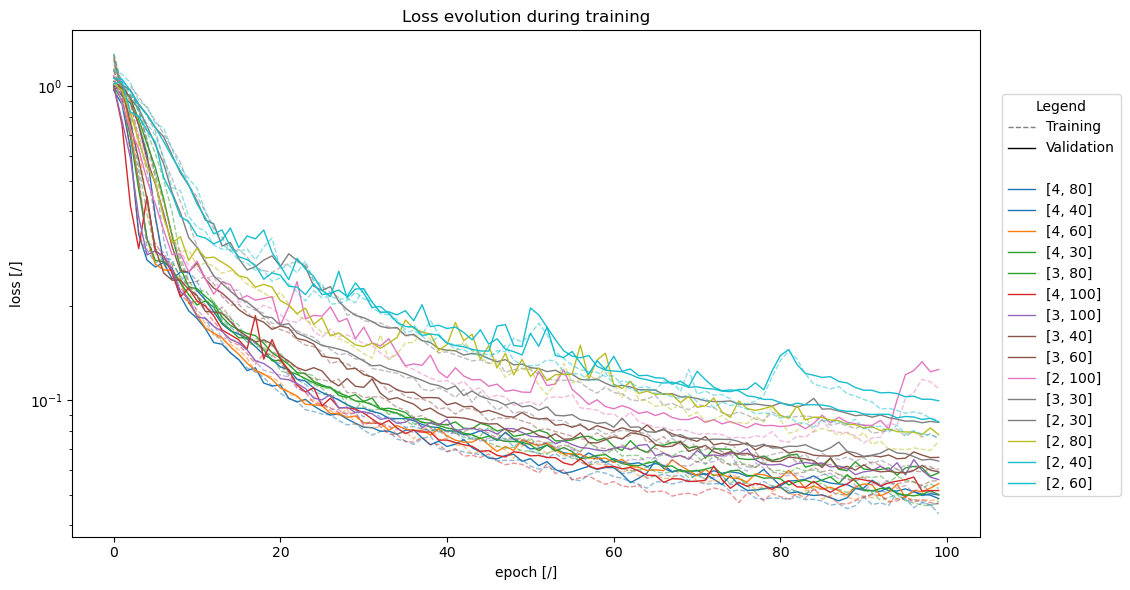

In [54]:
# Your existing code for preparing the data
_configs = sorted([(np.min(v['val_loss']), k) for k, v in results.items()])
configs = _configs
configs = sorted(configs)
configs = [x[1] for x in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(configs)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data but collect the handles for the legend
config_handles = []
for i, capacity in enumerate(configs):
    # Store only the validation line handles for the legend
    l = len(results[capacity]['train_loss'])
    h = ax.plot(np.arange(l), results[capacity]['train_mape'], alpha=.5, ls='--', lw=1, c=c[i])[0]
    h2 = ax.plot(np.arange(l), results[capacity]['val_mape'], ls='-', lw=1, c=c[i])[0]
    config_handles.append(h2)

# Create custom handles for the line style legend
line_style_handles = [
    Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
    Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
]

# Get the current position and size of the axis
box = ax.get_position()
# Reduce the width of the axis to make room for the legend
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Combine both sets of handles and labels
all_handles = line_style_handles + config_handles
all_labels = ['Training', 'Validation', ''] + [str([int(x) for x in cfg]) for cfg in configs]

# Create a single legend with both line styles and configurations
plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
              title="Legend")

ax.set_title("Loss evolution during training")
ax.set_yscale('log')
ax.set_ylabel("loss [/]")
ax.set_xlabel("epoch [/]")
plt.tight_layout()
# Adjust right padding to make room for the legend
plt.show()

## Activation function

In [55]:
if False:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss+MSE_no_noise_activation_function")

    TRAIN_BATCH_SIZE = 512
    VAL_BATCH_SIZE = 256
    N_EPOCH = 200
    LR = 5e-4

    log_step = -1

    kfold = 5
    activation_values = ['relu', 'gelu', 'tanh', 'sigmoid', 'softplus',
                         'leaky_relu', 'leaky_relu', 'leaky_relu',
                         'leaky_relu', 'leaky_relu', 'leaky_relu',
                         'leaky_relu']
    activation_params_values = [None, None, None, None, None,
                                {'negative_slope': 1e-1}, {'negative_slope': 1e-2}, {'negative_slope': 1e-3},
                                {'negative_slope': 1e-4}, {'negative_slope': 1e-5}, {'negative_slope': 1e-6},
                                {'negative_slope': 1e-7}]
    dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_2000.hdf5"
    ds = FixedPrattTrussDatasetSingleTarget(dataset_path)
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for activation, activation_params in zip(activation_values, activation_params_values):
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': [40 for _ in range(4)],
                                             'output_dim': 1,
                                             'activation': activation,
                                             'activation_params': activation_params,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, 1e-4,
                                         {
                                             'training': BasicDataset('2_000', dataset_path, 2_000, kfold,
                                                                      "60m long 7,5m high pratt truss"),
                                         }, kfold, log_step)
                futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

2025/03/18 15:23:32 INFO mlflow.tracking.fluent: Experiment with name 'StiffnessToLoadLoss+MSE_no_noise_activation_function' does not exist. Creating a new experiment.


🏃 View run ambitious-auk-743 at: http://127.0.0.1:5000/#/experiments/725715674563494578/runs/ae61d2555b06463aaefbcf3ef17f016d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/725715674563494578
🏃 View run abundant-stag-236 at: http://127.0.0.1:5000/#/experiments/725715674563494578/runs/536e4cb692974240a7dbe6c740a8ee72
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/725715674563494578
🏃 View run illustrious-deer-185 at: http://127.0.0.1:5000/#/experiments/725715674563494578/runs/dbf27b8ef42d407bb5e5dd9ca5e94f43
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/725715674563494578
🏃 View run languid-conch-731 at: http://127.0.0.1:5000/#/experiments/725715674563494578/runs/f02fa488dac04ff49208c0acf6439a6d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/725715674563494578
🏃 View run carefree-bat-558 at: http://127.0.0.1:5000/#/experiments/725715674563494578/runs/28f05102e5c747409afefcd55ac2f96d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/72

### Exploring the results

In [56]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss+MSE_no_noise_activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in combinations}
for k in combinations:
    (act, params) = k
    run_ids = runs_df[(runs_df['params.activation'] == act)
                      & (runs_df['params.activation_params'] == params)]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

if ('leaky_relu', 'None') in results:
    results[('leaky_relu', "{'negative_slope': 0.01}")] = results[('leaky_relu', 'None')]
    del results[('leaky_relu', 'None')]

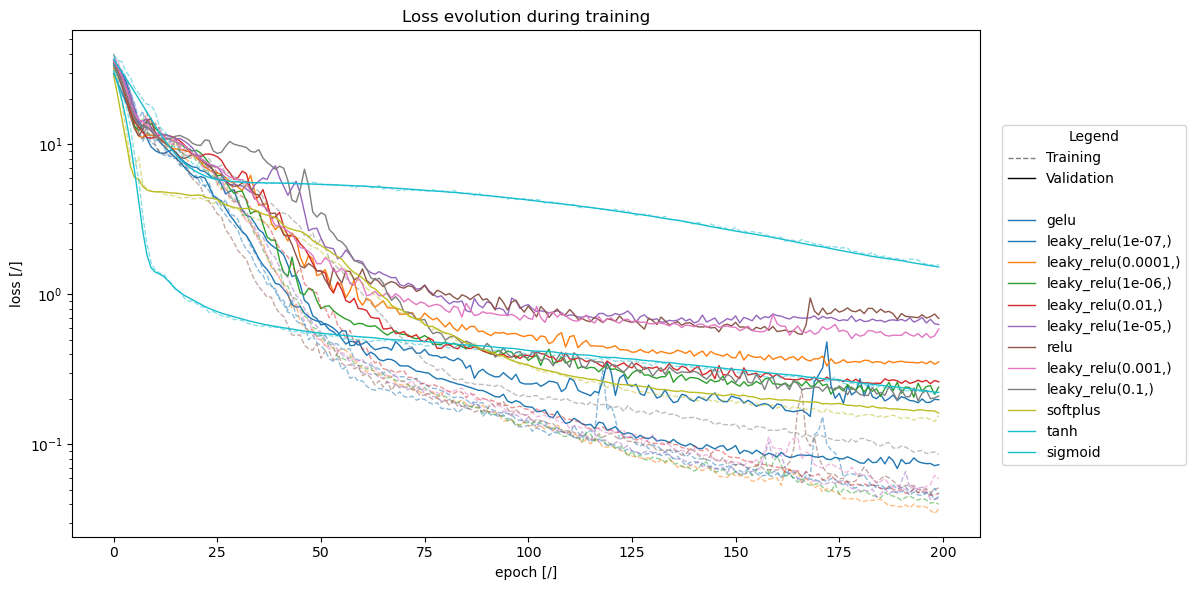

In [58]:
# Your existing code for preparing the data
configs = [x[1] for x in sorted([(np.min(v['val_mape']), k) for k, v in results.items()])]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(configs)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data but collect the handles for the legend
config_handles = []
for i, k in enumerate(configs):
    # Store only the validation line handles for the legend
    l = len(results[k]['train_loss'])
    h = ax.plot(np.arange(l), results[k]['train_loss'], alpha=.5, ls='--', lw=1, c=c[i])[0]
    h2 = ax.plot(np.arange(l), results[k]['val_loss'], ls='-', lw=1, c=c[i])[0]
    config_handles.append(h2)

# Create custom handles for the line style legend
line_style_handles = [
    Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
    Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
]

# Get the current position and size of the axis
box = ax.get_position()
# Reduce the width of the axis to make room for the legend
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Combine both sets of handles and labels
all_handles = line_style_handles + config_handles

labels = []
for act, params in configs:
    s = act
    if params != "None":
        s += tuple(ast.literal_eval(params).values()).__str__()
    labels.append(s)

all_labels = ['Training', 'Validation', ''] + labels

# Create a single legend with both line styles and configurations
plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
              title="Legend")

ax.set_title("Loss evolution during training")
ax.set_yscale('log')
ax.set_ylabel("loss [/]")
ax.set_xlabel("epoch [/]")
plt.tight_layout()
# Adjust right padding to make room for the legend
plt.show()

## Learning rate

In [59]:
if False:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss+MSE_no_noise_learning_rate")

    TRAIN_BATCH_SIZE = 512
    VAL_BATCH_SIZE = 256
    N_EPOCH = 200
    LR = 5e-4

    kfold = 5
    dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_2000.hdf5"
    ds = FixedPrattTrussDatasetSingleTarget(dataset_path)
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for LR in sorted(np.hstack([f * np.logspace(-5, -2, 4) for f in [1, 2.5, 5, 7.5]])):
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': [30 for _ in range(4)],
                                             'output_dim': 1,
                                             'activation': 'gelu',
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, 1e-4,
                                         {
                                             'training': BasicDataset('2_000', dataset_path, 2_000, kfold,
                                                                      "60m long 7,5m high pratt truss"),
                                         }, kfold, log_step)
                futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

2025/03/19 12:22:31 INFO mlflow.tracking.fluent: Experiment with name 'StiffnessToLoadLoss+MSE_no_noise_learning_rate' does not exist. Creating a new experiment.


🏃 View run stylish-crane-137 at: http://127.0.0.1:5000/#/experiments/369777450016355552/runs/419fbad3cc054a959e8f73b013cc972e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/369777450016355552
🏃 View run bustling-fish-400 at: http://127.0.0.1:5000/#/experiments/369777450016355552/runs/a13507d02dbe4d6ebbc2e36277d9417d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/369777450016355552
🏃 View run fortunate-eel-848 at: http://127.0.0.1:5000/#/experiments/369777450016355552/runs/b96f8f68e62a45dc95d0245f4395db08
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/369777450016355552
🏃 View run adventurous-bat-566 at: http://127.0.0.1:5000/#/experiments/369777450016355552/runs/39590daaa6b744459f1e52cbf10605d4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/369777450016355552
🏃 View run useful-perch-910 at: http://127.0.0.1:5000/#/experiments/369777450016355552/runs/641836d13e4b43c9944163a5f5a01f68
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/369

### Exploring the results

In [60]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss+MSE_no_noise_learning_rate")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

combinations = set(runs_df['params.learning_rate'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in combinations}
for lr in combinations:
    run_ids = runs_df[runs_df['params.learning_rate'] == lr]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[lr][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

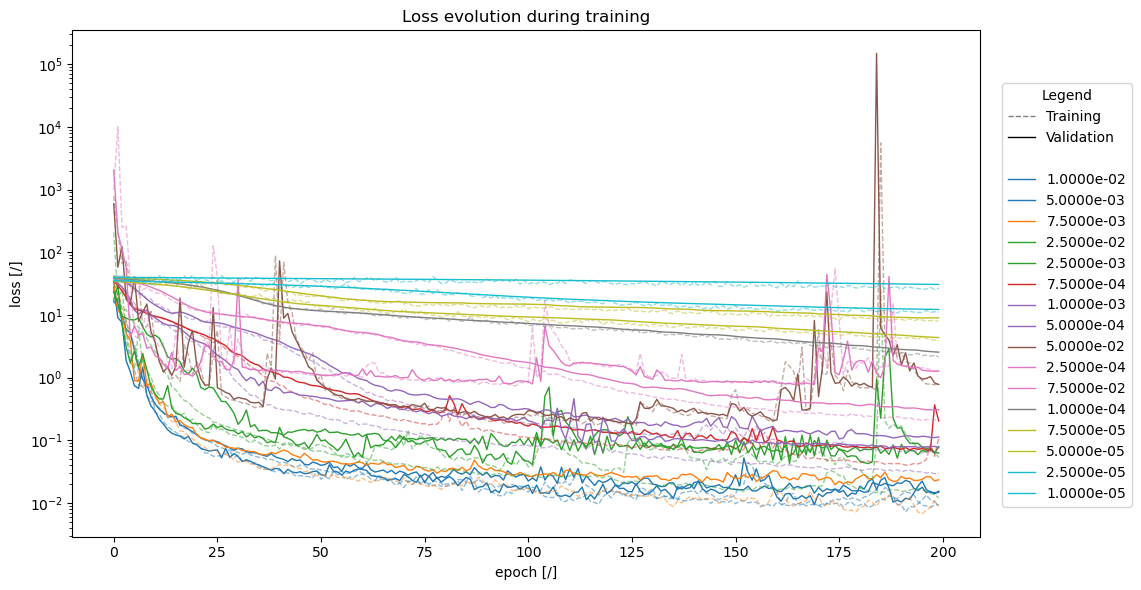

In [61]:
# Your existing code for preparing the data
configs = sorted([(np.min(v['val_loss']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(configs)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data but collect the handles for the legend
metric = 'loss'
config_handles = []
for i, k in enumerate(configs):
    # Store only the validation line handles for the legend
    l = len(results[k][f'train_{metric}'])
    h = ax.plot(np.arange(l), results[k][f'train_{metric}'], alpha=.5, ls='--', lw=1, c=c[i])[0]
    h2 = ax.plot(np.arange(l), results[k][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
    config_handles.append(h2)

# Create custom handles for the line style legend
line_style_handles = [
    Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
    Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
]

# Get the current position and size of the axis
box = ax.get_position()
# Reduce the width of the axis to make room for the legend
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Combine both sets of handles and labels
all_handles = line_style_handles + config_handles
all_labels = ['Training', 'Validation', ''] + [f"{float(c):.4e}" for c in configs]

# Create a single legend with both line styles and configurations
plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
              title="Legend")

ax.set_title("Loss evolution during training")
ax.set_yscale('log')
ax.set_ylabel("loss [/]")
ax.set_xlabel("epoch [/]")
plt.tight_layout()
# Adjust right padding to make room for the legend
plt.show()

# Testing

In [63]:
if True:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss+MSE_no_noise_dataset_size")

    VAL_BATCH_SIZE = 8192
    N_EPOCH = 200
    log_step = -1
    LR = 1e-2
    kfold = 5

    sizes = [100, 200, 500, 1000, 2000, 10000, 20000, 50000, 100000]
    batch_size_values = [int(min(np.power(2, np.floor(np.log2(n)) - 1), 4096)) for n in sizes]
    dataset_path_values = [f"data/dataset/pratt_truss_bridge/single_ea/train_{n}.hdf5" for n in sizes]

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
            size = sizes[i]
            ds = FixedPrattTrussDatasetSingleTarget(dataset_path)
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': [30 for _ in range(4)],
                                             'output_dim': 1,
                                             'activation': 'gelu',
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, 1e-3,
                                         {
                                             'training': BasicDataset(f'{size}', dataset_path, size, kfold,
                                                                      "60m long 7,5m high pratt truss"),
                                         }, kfold, log_step)
                futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

2025/03/19 13:11:27 INFO mlflow.tracking.fluent: Experiment with name 'StiffnessToLoadLoss+MSE_no_noise_dataset_size' does not exist. Creating a new experiment.


🏃 View run adaptable-pig-235 at: http://127.0.0.1:5000/#/experiments/815651529322977859/runs/e97503430dde464e8c0e1c0156c95b4f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815651529322977859
🏃 View run able-stoat-7 at: http://127.0.0.1:5000/#/experiments/815651529322977859/runs/9f4b6d4723c8454aa3a13b50e85ce4ad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815651529322977859
🏃 View run legendary-kit-512 at: http://127.0.0.1:5000/#/experiments/815651529322977859/runs/212a5a3bd9da4c279d4bf650b6e74ca0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815651529322977859
🏃 View run learned-yak-860 at: http://127.0.0.1:5000/#/experiments/815651529322977859/runs/996b0deb51ca4ea380bcff9156c2e7f4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815651529322977859
🏃 View run adaptable-hawk-649 at: http://127.0.0.1:5000/#/experiments/815651529322977859/runs/8994baf94d7848b2b3fb09415dc1dde5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/8156515293

### Results exploration

In [64]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss+MSE_no_noise_dataset_size")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

combinations = set(runs_df['params.train_size'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in combinations}
for size in combinations:
    run_ids = runs_df[runs_df['params.train_size'] == size]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

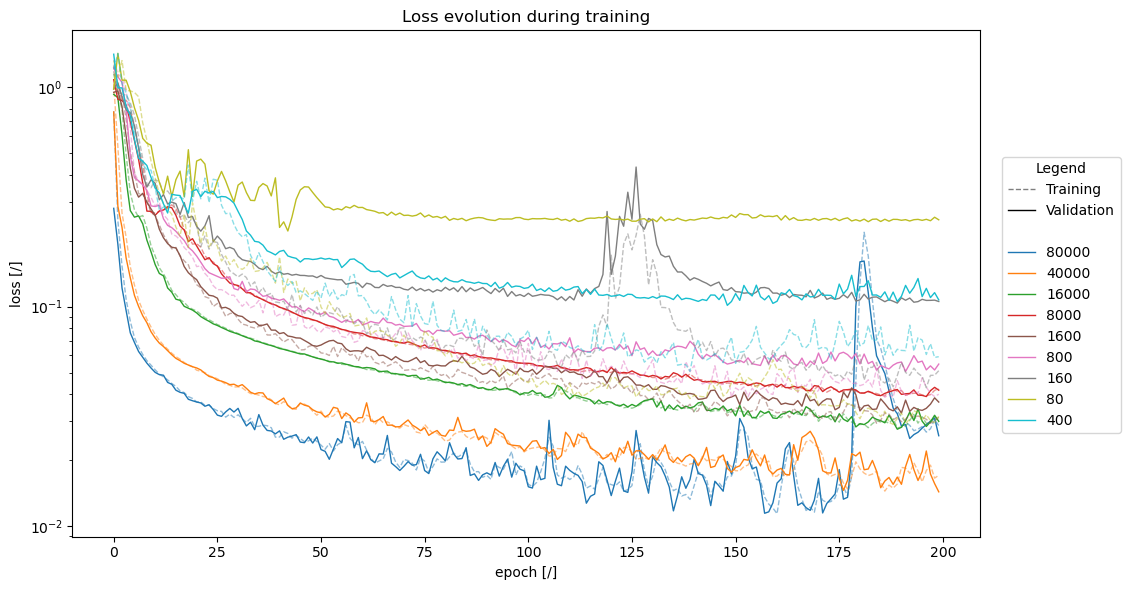

In [65]:
# Your existing code for preparing the data
configs = sorted([(np.min(v['val_loss']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(configs)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data but collect the handles for the legend
config_handles = []
for i, k in enumerate(configs):
    # Store only the validation line handles for the legend
    h = ax.plot(np.arange(len(results[k]['train_mape'])), results[k]['train_mape'], alpha=.5, ls='--', lw=1, c=c[i])[0]
    h2 = ax.plot(np.arange(len(results[k]['val_mape'])), results[k]['val_mape'], ls='-', lw=1, c=c[i])[0]
    config_handles.append(h2)

# Create custom handles for the line style legend
line_style_handles = [
    Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
    Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
]

# Get the current position and size of the axis
box = ax.get_position()
# Reduce the width of the axis to make room for the legend
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Combine both sets of handles and labels
all_handles = line_style_handles + config_handles
all_labels = ['Training', 'Validation', ''] + [f"{int(c)}" for c in configs]

# Create a single legend with both line styles and configurations
plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
              title="Legend")

ax.set_title("Loss evolution during training")
ax.set_yscale('log')
ax.set_ylabel("loss [/]")
ax.set_xlabel("epoch [/]")
plt.tight_layout()
# Adjust right padding to make room for the legend
plt.show()

# Test on "real" data

In [66]:
if True:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss+MSE_no_noise_test_noise")

    VAL_BATCH_SIZE = 8192
    N_EPOCH = 300
    log_step = -1
    LR = 1e-2
    kfold = -1

    sizes = [100, 200, 500, 1000, 2000, 10000, 20000]
    batch_size_values = [int(min(np.power(2, np.floor(np.log2(n)) - 1), 4096)) for n in sizes]
    dataset_path_values = [f"data/dataset/pratt_truss_bridge/single_ea/train_{n}.hdf5" for n in sizes]

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for f in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
                size = sizes[i]
                train_dataset = FixedPrattTrussDatasetSingleTarget(dataset_path)
                test_dataset = FixedPrattTrussDatasetSingleTarget(
                    "data/dataset/pratt_truss_bridge/single_ea/test_20000.hdf5",
                    f_noise_length=None,
                    f_noise_loads=lambda size: np.random.normal(1, f * 0.005, size=size),
                    f_noise_strain=lambda size: np.random.normal(1, f * 0.005, size=size),
                    f_noise_displacement=lambda size: np.random.normal(1, f * 0.005, size=size)
                )
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': [30 for _ in range(4)],
                                             'output_dim': 1,
                                             'activation': 'gelu',
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None
                                         },
                                         train_dataset, test_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, 1e-3,
                                         {
                                             'training': BasicDataset(f'{size}', dataset_path, size, kfold,
                                                                      "60m long 7,5m high pratt truss"),
                                             'test': BasicDataset(f'20_000',
                                                                  "data/dataset/pratt_truss_bridge/single_ea/test_20000.hdf5",
                                                                  20000, kfold, "60m long 7,5m high pratt truss"),
                                         }, kfold, log_step, {'noise_factor': f})
                futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

2025/03/19 13:55:59 INFO mlflow.tracking.fluent: Experiment with name 'StiffnessToLoadLoss+MSE_no_noise_test_noise' does not exist. Creating a new experiment.


🏃 View run amazing-shrew-209 at: http://127.0.0.1:5000/#/experiments/739267251816914663/runs/9e627f8c536f4517aa4175ed94d7501f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/739267251816914663
🏃 View run chill-fly-626 at: http://127.0.0.1:5000/#/experiments/739267251816914663/runs/d55ca92ee259448385b639d92ea0d065
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/739267251816914663
🏃 View run dapper-dove-33 at: http://127.0.0.1:5000/#/experiments/739267251816914663/runs/7088b2c3b01d44258bb9f0c90bbaec9c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/739267251816914663
🏃 View run smiling-skink-595 at: http://127.0.0.1:5000/#/experiments/739267251816914663/runs/a9bdf9e78aea4043af4f68ecbddca748
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/739267251816914663
🏃 View run shivering-gnu-978 at: http://127.0.0.1:5000/#/experiments/739267251816914663/runs/dba9f87822f144f6a2146b4eb1d67cd1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/73926725181

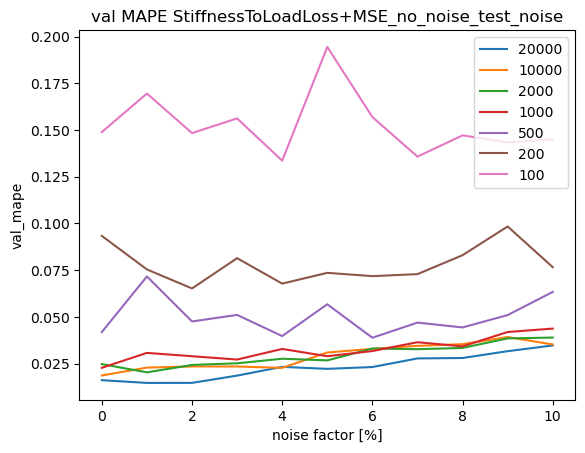

In [67]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss+MSE_no_noise_test_noise")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

noise_factors = {}
for size in runs_df['params.train_size'].unique():
    df = runs_df[runs_df['params.train_size'] == size]
    noise_factors[size] = []
    for noise in df['params.noise_factor'].unique():
        noise_factors[size].append(noise)
    noise_factors[size].sort(key=lambda k: float(k))

values = {}
client = mlflow.tracking.MlflowClient()
for size, factors in noise_factors.items():
    values[size] = {metric_name: [] for metric_name in metrics_names}
    for factor in factors:
        run_ids = runs_df[(runs_df['params.train_size'] == size) & (runs_df['params.noise_factor'] == factor)][
            'run_id']
        for metric_name in metrics_names:
            metrics_values = [[m.value for m in client.get_metric_history(run_id, metric_name)] for run_id in
                              run_ids]
            if 'r2' in metric_name:
                values[size][metric_name].append(np.max(np.hstack(metrics_values)))
            else:
                values[size][metric_name].append(np.min(np.hstack(metrics_values)))

for metric_name in ['val_mape']:
    fig, ax = plt.subplots()
    for size in values.keys():
        ax.plot([int(f) for f in noise_factors[size]], values[size][metric_name], label=size)
    ax.set_title(f"val MAPE StiffnessToLoadLoss+MSE_no_noise_test_noise")
    ax.legend()

    ax.set_ylabel(metric_name)
    ax.set_xlabel("noise factor [%]")